@2025-2-21用于分析行为数据和神经数据相关性
输入
+ 根据神经数据时间戳对齐的行为数据
+ calcium trace数据

In [2]:
import sys
sys.path.append(r"D:\data analysis\code\WBI_analysis")  # 例如 r"C:\Users\YourName\Project"
import AnalysisMethod

In [3]:
import cv2
import os
import pandas as pd
import numpy as np
from scipy.ndimage import label
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from scipy.ndimage import grey_opening,grey_closing
from matplotlib.gridspec import GridSpecFromSubplotSpec
import AnalysisMethod as am
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
import matplotlib as mpl
import warnings
import argparse
from matplotlib.gridspec import GridSpec
warnings.filterwarnings('ignore')
from tifffile import imread
mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 96
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.bbox'] = 'tight'

In [4]:
# 神经钙信号数据导入
p_f = r'Z:\data space+\C. elegans chemotaxis\2025_WBI\20250115-16WBI\0116_05'
calcium_intensity= np.load(os.path.join(p_f, 'calcium_intensity.npy'))
save_p = p_f.split('calcium_intensity.npy')[0]
print(p_f)
print('文件大小:neuron*timestamp',calcium_intensity.shape)

Z:\data space+\C. elegans chemotaxis\2025_WBI\20250115-16WBI\0116_05
文件大小:neuron*timestamp (93, 3804)


In [5]:
# 预处理
scale = 1.5
for i in range(calcium_intensity.shape[0]):
    calcium_intensity[i] = (cv2.blur(calcium_intensity[i], (1, 7))*scale)[:,0]

In [6]:
# 导入神经时间戳+行为数据
f_nt_motion = [f for f in os.listdir(p_f) if 'NeuralAlignMotion' in f][0]
df_n_t = pd.read_csv(os.path.join(p_f, f_nt_motion), index_col=0)

In [7]:
# 将神经数据与行为数据合并  
calcium_intensity_T = calcium_intensity.T
# 创建列名
col_neuron_names = [f"{i+1}" for i in range(calcium_intensity_T.shape[1])]
df_calcium = pd.DataFrame(calcium_intensity_T, columns=col_neuron_names)
# 按照行索引合并
df_cal_motion = pd.concat([df_calcium, df_n_t], axis=1)

In [8]:
# 将PCA结果和行为数据合并
# PCA
cov = np.cov(calcium_intensity)
ev,evec = np.linalg.eig(cov)
sort_idx=np.argsort(ev)[::-1]
ev=ev[sort_idx]
evec=evec[:,sort_idx]
expr = np.sum(ev[:2])/np.sum(ev)
xn= calcium_intensity.T @ evec.real

# 创建列名
column_names = [f"PC{i+1}" for i in range(xn.shape[1])]
# PCA结果转为 DataFrame
df_PCA = pd.DataFrame(xn, columns=column_names)

# 合并数据
df_PCA_motion = pd.concat([df_PCA, df_n_t], axis=1)

In [9]:
# 对数据进行平滑
# 平滑速度
window_size = 15
# 计算移动平均值
df_PCA_motion['smoothed_speed'] = df_PCA_motion['speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑角速度
window_size = 15
# 计算移动平均值
df_PCA_motion['smoothed_agl_speed'] = df_PCA_motion['agl_speed'].rolling(window=window_size, min_periods=1).mean()
# 平滑ctx
window_size = 15
# 计算移动平均值
df_PCA_motion['smoothed_CTX'] = df_PCA_motion['CTX_left'].rolling(window=window_size, min_periods=1).mean()
# 平滑PC1和PC2
df_PCA_motion['smoothed_PC1'] = df_PCA_motion['PC1'].rolling(window=window_size, min_periods=1).mean()
df_PCA_motion['smoothed_PC2'] = df_PCA_motion['PC2'].rolling(window=window_size, min_periods=1).mean()

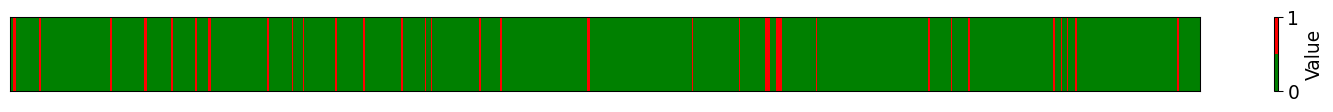

start_indices [   9   93  321  429  514  590  633  821  901  935 1038 1127 1248 1324
 1344 1497 1565 1844 2178 2327 2411 2447 2573 2931 3004 3060 3331 3356
 3377 3401 3727 3778]
end_indices [  18   97  324  435  520  596  641  826  902  938 1042 1133 1254 1328
 1347 1502 1569 1852 2182 2332 2426 2466 2577 2936 3008 3065 3337 3359
 3378 3406 3733 3778]


In [10]:
# 可视化重定向的位置，找到索引
vector = df_PCA_motion.Reorientation.values
remove_event = False

# 将一维向量扩展为二维（例如 1 行或 1 列）
heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
# Define two colors
colors = ['green', 'red']
# Create a ListedColormap
two_color_cmap = ListedColormap(colors)

if remove_event:
    # Define the size of the structuring element
    structure_size = 5
    # Perform opening
    opened_vector = grey_opening(heatmap_data, size=structure_size)
    structure_size = 13
    # Perform closing
    vector = grey_closing(opened_vector, size=structure_size)

    plt.figure(figsize=(20, 1))  # 设置热图大小
    plt.imshow(opened_vector, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
    plt.colorbar(label='Value')  # 添加颜色条
    plt.title('Removed small turnings')
    plt.xticks()  # 设置x轴刻度
    plt.yticks([])  # 隐藏y轴刻度
    # plt.title("Heatmap of 1D Vector")
    plt.show()
else:
    # 绘制热图
    plt.figure(figsize=(20, 1))  # 设置热图大小
    plt.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
    plt.colorbar(label='Value')  # 添加颜色条
    plt.xticks([])  # 设置x轴刻度
    plt.yticks([])  # 隐藏y轴刻度
    # plt.title("Heatmap of 1D Vector")
    plt.show()


# 找到Reorientation分隔的起始点
# np.diff计算临近点的差值，随后返回索引
start_indices = np.where(np.diff(np.insert(vector, 0, 0)) == 1)[0]
end_indices = np.where(np.diff(np.append(vector, 0)) == -1)[0]
print('start_indices', start_indices)
print('end_indices', end_indices)

## Hierarchical Clustering and Plot Traces
+ hierarchical clutering and sort the neurons
+ correlation matrix sorted by clustering result
+ Align behavior features with neural traces
+ Align PC component with neural traces

In [11]:
calcium_intensity.shape

(93, 3804)

In [12]:
def draw_calcium_curve(calcium_intensity, smooth_kernel=None, save=True,fig_size=None, scale=1):

    plt.figure(figsize=fig_size)
    num_neurons, num_timepoints = calcium_intensity.shape
    colors = ['orangered', 'blue', 'limegreen', 'purple', 'gold', 'cyan', 'magenta', 'coral', 'skyblue', 'orange']
    import cv2
    for i in range(calcium_intensity.shape[0]):
        color = colors[i % len(colors)]  # 循环使用颜色列表
        if smooth_kernel:
            smooth_line_data = cv2.blur(calcium_intensity[i], (1, 3))*scale
        else:
            line_data = calcium_intensity[i]*scale
        smooth_line_data = cv2.blur(calcium_intensity[i], (1, 7))*scale
        plt.plot(smooth_line_data + i, color=color, linestyle='-', label='A' if i == 0 else "",linewidth=1)  # 只显示第一个标签
        plt.scatter(y=line_data+i,x=np.arange(line_data.shape[0]),color=color, linestyle='-', label='A' if i == 0 else "",s=1)  # 只显示第一个标签
        if i in bound:
            plt.axhline(y=i-0.2, color='k', linestyle='dashdot', linewidth=4, c='r')  # 在y轴索引位置画一条虚线
        # 在每一行的右侧添加纵轴范围标注
        # plt.text(num_timepoints - 5, i + (y_max - y_min) / 2, f'{y_min:.2f} to {y_max:.2f}', 
        #      color=color, fontsize=10, va='center')
    plt.xlabel("Time point",fontsize=20)  # X轴标签
    plt.ylabel("Intensity",fontsize=20)  # Y轴标签
    # 设置 y 轴范围
    plt.ylim(bottom=0-1, top=num_neurons+1)  # 设置 y 轴的最小值为 0，最大值为 num_neurons

    # 每隔 5 个单位标注一个 y ticks
    y_ticks = np.arange(0, num_neurons + 1, 1)  # 生成从 0 到 num_neurons 的刻度，每隔 5 个单位
    plt.yticks(y_ticks,fontsize=20)  # 设置 y 轴刻度
    x_ticks = np.arange(0, num_timepoints + 1, 200)  # 生成从 0 到 num_neurons 的刻度，每隔 5 个单位
    plt.xticks(x_ticks,fontsize=20,rotation=45)  # 设置 y 轴刻度
    plt.tight_layout()
    if save:
        if smooth_kernel:
            plt.savefig(f'{signal_save_path}/cluster_calcium_curve(smooth_{smooth_kernel}).png')
        else:
            plt.savefig(f'{signal_save_path}/cluster_calcium_curve.png')

In [13]:
# def PlotPmdCluster(w_p2m,idx_pmd,idx_m1,bound_pmd,bound_m1,link,aff,vmin,vmax,threshold,xlabel,ylabel,cmap,level):
#     '''
#     w_p2m: 数据矩阵，用于绘制热图和聚类分析。
#     idx_pmd, idx_m1: 用于对行和列排序的索引。
#     bound_pmd, bound_m1: 热图中行和列的边界，用于分区的虚线绘制。
#     link, aff: 聚类方法的链接方式和距离度量方式。
#     vmin, vmax: 热图的颜色范围。
#     threshold: 树状图的颜色阈值。
#     xlabel, ylabel: 热图的轴标签。
#     cmap: 热图的颜色映射。
#     level: 树状图的截断层数。
#     '''
#     fig = plt.figure(figsize=(7, 6))
#     ax = plt.subplot(1,1,1)
#     ax.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
#     ax.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
#     ax.set_xticks([])  # 移除x轴的刻度标记
#     ax.set_yticks([])
#     for spine in ax.spines.values():
#         spine.set_visible(False)
#     # plt.title(title)
#     gs00 = GridSpecFromSubplotSpec(3, 3, subplot_spec=ax.get_subplotspec(), wspace=0.04, hspace=0.02,
#                                    width_ratios=[0.2, 6.5, 1], height_ratios=[1, 6.5, 0.2])
    
#     # 热图
#     ax0 = fig.add_subplot(gs00[1, 1])
#     # 树状图在上方
#     ax1 = fig.add_subplot(gs00[0, 1])
#     # ax2 = fig.add_subplot(gs00[0, 0])
    
#     # 聚类并将聚类的结果画在相关性矩阵旁边
#     model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link, affinity=aff)
#     model = model.fit(w_p2m)
#     am.plot_dendrogram(model, truncate_mode="level", p=level, \
#                     no_labels=True, orientation='bottom', ax=ax1,color_threshold=threshold)
#     ax1.set_xlim(ax1.get_xlim())
#     # ax1.set_xlim([0.5,2])
#     ax1.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
#     ax1.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
#     ax1.set_xticks([])  # 移除x轴的刻度标记
#     ax1.set_yticks([])
#     ax1.invert_yaxis()
#     for spine in ax1.spines.values():
#         spine.set_visible(False)
#     ax_list=list(np.linspace(0,w_p2m.shape[0],24,dtype=int))
#     X_sort = w_p2m[idx_pmd][:,idx_m1]
    
#     # 重新排序之后画热图
    
# #     ax0.set_aspect(1)

#     cbar_ax = fig.add_subplot(gs00[1,0])  # [left, bottom, width, height]
#     # 设置热图的corlorbar
#     ax0=sns.heatmap(X_sort, ax=ax0, cmap=cmap, vmin=vmin, vmax=vmax,cbar=True, cbar_ax = cbar_ax, square=True)
# #     cbar=fig.colorbar(ax0.collections[0], cax=cbar_ax)
#     cbar_ax.yaxis.set_ticks_position("left")  # 将刻度放到左侧
#     cbar_ax.yaxis.set_label_position("left")  # 将标签放到左侧
# #     ax0.set_xticks(ax_list, ax_list,fontsize=10)
# #     ax0.set_yticks(ax_list, ax_list,fontsize=10)

#     # ax0.invert_yaxis()
# #     ax0.set_xlabel(xlabel,fontsize=16)
# #     ax0.set_ylabel(ylabel,fontsize=16)
#     ax0.set_xticks([])
#     ax0.set_yticks([])
#     print('bound_pwd',bound_pmd)
    
#     # 画边界
# #     boundary = 0
# #     idx_bound=np.zeros(len(bound_pmd)+1)
#     for i in bound_pmd:
#         ax0.axhline(y=i, color='white', linestyle='--')
#     for i in bound_m1:
#         ax0.axvline(x=i, color='white', linestyle='--')
        
#     # 移除多余的轴（右侧或下方）
#     ax_empty = fig.add_subplot(gs00[1, 2])
#     ax_empty.axis("off")  # 空白占位，不显示内容
    
#     plt.tight_layout()
# #     for i in range(len(bound_pmd)-1):
# #         boundary += bound_pmd[i]
# #         idx_bound[i+1]=boundary
        
# #         print('boundary', boundary)
# #         print('idx_bound:',idx_bound)
# #         # print(boundary)
# #         ax0.axhline(y=boundary, color='white', linestyle='--')
# #     idx_bound[-1]=400
# #     boundary = 0
# #     for i in range(len(bound_m1)-1):
# #         boundary += bound_m1[i]  
# #         # print(boundary)
# #         ax0.axvline(x=boundary, color='white', linestyle='--')
# #     return idx_bound.astype(int),fig
#     return fig

In [14]:
# def PlotPmdCluster(w_p2m,idx_pmd,idx_m1,bound_pmd,bound_m1,link,aff,vmin,vmax,threshold,xlabel,cmap,level):
#     '''
#     w_p2m: 数据矩阵，用于绘制热图和聚类分析。
#     idx_pmd, idx_m1: 用于对行和列排序的索引。
#     bound_pmd, bound_m1: 热图中行和列的边界，用于分区的虚线绘制。
#     link, aff: 聚类方法的链接方式和距离度量方式。
#     vmin, vmax: 热图的颜色范围。
#     threshold: 树状图的颜色阈值。
#     xlabel, ylabel: 热图的轴标签。
#     cmap: 热图的颜色映射。
#     level: 树状图的截断层数。
#     '''
#     fig = plt.figure(figsize=(8, 6))
#     ax = plt.subplot(1,1,1)
#     ax.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
#     ax.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
#     ax.set_xticks([])  # 移除x轴的刻度标记
#     ax.set_yticks([])
#     for spine in ax.spines.values():
#         spine.set_visible(False)
#     # plt.title(title)
#     gs00 = GridSpecFromSubplotSpec(3, 3, subplot_spec=ax.get_subplotspec(), wspace=0.3, hspace=0.02,
#                                    width_ratios=[0.2, 6.5, 1], height_ratios=[1, 6.5, 0.2])
    
#     # 热图
#     ax0 = fig.add_subplot(gs00[1, 1])
#     # 树状图在上方
#     ax1 = fig.add_subplot(gs00[0, 1])
#     # ax2 = fig.add_subplot(gs00[0, 0])
    
#     # 聚类并将聚类的结果画在相关性矩阵旁边
#     model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link, affinity=aff)
#     model = model.fit(w_p2m)
#     am.plot_dendrogram(model, truncate_mode="level", p=level, \
#                     no_labels=True, orientation='bottom', ax=ax1,color_threshold=threshold)
#     ax1.set_xlim(ax1.get_xlim())
#     # ax1.set_xlim([0.5,2])
#     ax1.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
#     ax1.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
#     ax1.set_xticks([])  # 移除x轴的刻度标记
#     ax1.set_yticks([])
#     ax1.invert_yaxis()
#     for spine in ax1.spines.values():
#         spine.set_visible(False)
#     ax_list=list(np.linspace(0,w_p2m.shape[0],24,dtype=int))
#     X_sort = w_p2m[idx_pmd][:,idx_m1]
    
#     # 重新排序之后画热图
#     cbar_ax = fig.add_subplot(gs00[1,0])  # [left, bottom, width, height]
#     # 设置热图的corlorbar
#     ax0=sns.heatmap(X_sort, ax=ax0, cmap=cmap, vmin=vmin, vmax=vmax,cbar=True, cbar_ax = cbar_ax, square=False)
#     cbar_ax.yaxis.set_ticks_position("left")  # 将刻度放到左侧
#     cbar_ax.yaxis.set_label_position("left")  # 将标签放到左侧
#     ax0.set_xticks(ax_list, ax_list,fontsize=10)
#     ax0.set_yticks(ax_list, ax_list,fontsize=10)
#     # 逆转y轴以对齐钙信号热图
#     ax0.invert_yaxis()
#     ax0.set_xlabel(xlabel,fontsize=16)
#     print('bound_pwd',bound_pmd)
    
#     # 画边界
#     for i in bound_pmd:
#         ax0.axhline(y=i, color='white', linestyle='--')
#     for i in bound_m1:
#         ax0.axvline(x=i, color='white', linestyle='--')
        
#     # 移除多余的轴（右侧或下方）
#     ax_empty = fig.add_subplot(gs00[1, 2])
#     ax_empty.axis("off")  # 空白占位，不显示内容
    
#     plt.tight_layout()
#     return fig

In [15]:
def calcium_heatmap(calcium_intensity,df, col_draw,  neuron_ids, show_id_stride=20, show_vol_stride=10,
                    heatmap_range=(None,0.5),
                    unit_w=0.05, unit_h = 0.2, cal_height_ratio=20,start_indices=[], wspace=0.125, hspace = 0.15
                    ,bound_cluster = [],
                    font_size=90, font_color='black',smooth_kernel=10,
                   idx=None,link=None,aff=None,vmin=0,vmax=1,threshold=None,xlabel='',cmap='jet',level=None):
    '''
    df： PCA和行为对齐
    col_draw: 需要画图的列名
    unit_w: 单位宽度(对应时间)
    unit_h: 单位高度（对应神经元数量）
    cal_height_ratio : 预期钙信号热图相对运动参数等条图的高度比例
    '''
    # 神经元数量及时间长度
    num_neurons, num_vols = calcium_intensity.shape
    DRR0 = calcium_intensity
    
    # 平滑数据
    if smooth_kernel:
        for i,k in enumerate(DRR0):
            DRR0[i] = cv2.blur(k,(1,smooth_kernel))[:,0]
            
    # 绘图
    num_row = len(col_draw)+2
    height_ratios = [1.5 for i in range(num_row-1)]
    height_ratios.append(cal_height_ratio)
    
    gs = GridSpec(num_row, 4, height_ratios=height_ratios, width_ratios=[0.3,25,50, 0.3], wspace=wspace, hspace=hspace)
    fig_h = (unit_h*num_neurons)/ cal_height_ratio *  sum(height_ratios)
    # 创建图形
    fig = plt.figure(figsize=(unit_w*num_vols+unit_h*num_neurons*1.1, fig_h))
    
    
    w_p2m = np.corrcoef(calcium_intensity)
    # 热图
    ax0 = fig.add_subplot(gs[-1, 1])
    # 树状图在上方
    ax1 = fig.add_subplot(gs[-4:-1, 1])
    # ax2 = fig.add_subplot(gs00[0, 0])
    
    # 聚类并将聚类的结果画在相关性矩阵旁边
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage=link, affinity=aff)
    model = model.fit(w_p2m)
    
    # Override the default linewidth.
    mpl.rcParams['lines.linewidth'] = font_size*0.2
    am.plot_dendrogram(model, truncate_mode="level", p=level, \
                    no_labels=True, orientation='bottom', ax=ax1,color_threshold=threshold,
                   above_threshold_color='blue')
    ax1.set_xlim(ax1.get_xlim())
    # ax1.set_xlim([0.5,2])
    ax1.xaxis.set_ticks_position('none')  # 不显示x轴的刻度
    ax1.yaxis.set_ticks_position('none')  # 不显示y轴的刻度
    ax1.set_xticks([])  # 移除x轴的刻度标记
    ax1.set_yticks([])
    ax1.invert_yaxis()
    for spine in ax1.spines.values():
        spine.set_visible(False)
    ax_list=list(np.linspace(0,w_p2m.shape[0],24,dtype=int))
    X_sort = w_p2m[idx][:,idx]
    
    # 重新排序之后画热图
#     cbar_ax = fig.add_subplot(gs[-1,0])  # [left, bottom, width, height]
    cbar_ax = fig.add_axes([0.1, 0.15, 0.01, 0.4])
    # 设置热图的corlorbar
    ax0=sns.heatmap(X_sort, ax=ax0, cmap=cmap, vmin=vmin, vmax=vmax,cbar=True, cbar_ax = cbar_ax, square=False)
    cbar_ax.yaxis.set_ticks_position("left")  # 将刻度放到左侧
    cbar_ax.yaxis.set_label_position("left")  # 将标签放到左侧
    cbar_ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    cbar_ax.set_ylabel('Correlation', fontsize = font_size*1.25, labelpad = font_size*0.75)
    ax0.set_xticks(ax_list, ax_list,fontsize=font_size)
    ax0.set_yticks(ax_list, ax_list,fontsize=font_size)
    ax0.tick_params(axis = 'x', pad = font_size*0.75)
    ax0.tick_params(axis='y', labelrotation=0,pad = font_size*0.75)  # 将y轴标签设置为水平
    # 逆转y轴以对齐钙信号热图
    ax0.invert_yaxis()
    ax0.set_xlabel(xlabel,fontsize=font_size*1.25, labelpad = font_size*0.75)
    bound_pmd = bound_cluster
    bound_m1 = bound_cluster
    # 画边界
    for i in bound_pmd:
        ax0.axhline(y=i, color='white', linestyle='--')
    for i in bound_m1:
        ax0.axvline(x=i, color='white', linestyle='--')
    
    
    
    # 循环画运动参数
    for i, col in enumerate(col_draw):
        # 添加子图
        ax = fig.add_subplot(gs[i, 2])  # 第一行
        vector = df[col].values
        if (col != 'Reorientation'):
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            im = ax.imshow(heatmap_data, cmap='jet', aspect='auto')  # 绘制热图

            # 调整 colorbar 参数
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)
            if 'smoothed_' in col:
                col = col.replace('smoothed_', '')
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            cbar.ax.tick_params(labelsize=font_size*0.5, width=5, length=5, pad = font_size*0.25)  # 设置刻度大小和宽度
            # 设置标题和轴
            ax.set_xticks([])  # 隐藏x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度
        else:
            heatmap_data = vector[np.newaxis, :]  # 变为 1 行 N 列
            # Define two colors
            colors = ['green', 'red']
            # Create a ListedColormap
            two_color_cmap = ListedColormap(colors)
            im = ax.imshow(heatmap_data, cmap=two_color_cmap, aspect='auto')  # 选择 colormap
            # 添加颜色条
            cax = fig.add_subplot(gs[i, 3])  # colorbar 放在右侧
            cbar = plt.colorbar(im, cax=cax, fraction=0.5, orientation='vertical', aspect = 3)  # 通过 plt.colorbar 添加颜色条
            cbar.ax.set_title(col, fontsize = font_size*0.85, pad = font_size*0.25 )
            ax.set_xticks([])  # 设置x轴刻度
            ax.set_yticks([])  # 隐藏y轴刻度

    
    # 单独画轨迹分隔
    # 根据轨迹分隔索引画出色条
    
    # 生成颜色列表
    segment_boundaries = start_indices  # 分段区间
    colors = plt.cm.tab20(np.linspace(0, 1, len(start_indices)))[:, :3]  # 获取 RGB 值
    colors_list = [tuple(color) for color in colors]
    total_length = len(df)
    ax = fig.add_subplot(gs[-2, 2])  # 导数第二行
    bbox = ax.get_position()  # 返回 (x0, y0, width, height)
    # 根据子图高度动态设置矩形的高度
    rect_height = bbox.height * fig.get_size_inches()[1] * 0.8  # 乘以缩放因子调整适配性
    for i in range(len(start_indices) - 1):
        start = start_indices[i]
        end = start_indices[i + 1]
        color = colors_list[i % len(colors_list)]  # 循环分配颜色
        ax.add_patch(plt.Rectangle((start, 0), end - start, rect_height , color=color))
    # 设置坐标轴和图形属性
    ax.set_xlim(0, total_length)
    ax.set_ylim(0, rect_height)
#     ax.tick_params(labelsize = font_size)
    ax.axis('off')  # 隐藏坐标轴
    
    # 绘制钙信号热力图 
    ax = fig.add_subplot(gs[-1, 2])  # 最后一行
    heatmap=sns.heatmap(DRR0, vmin=heatmap_range[0], vmax=heatmap_range[1],
                        xticklabels=np.arange(num_vols)[::show_vol_stride],
                        yticklabels=neuron_ids[::show_id_stride],cbar=False,cmap='jet', ax=ax)
    
    cax = fig.add_axes([0.9, 0.15, 0.01, 0.4]) # [left, bottom, width, height]
#     cax = fig.add_subplot(gs[-1, 1])  # colorbar 放在右侧
    text_str = 'ΔR/R0'
    colorbar = plt.colorbar(heatmap.collections[0],cax=cax)
    colorbar.ax.tick_params(labelsize=font_size, pad = font_size*0.75)
    colorbar.set_label(text_str, fontsize = font_size*1.25, labelpad = font_size*0.75)
    
    # 竖直白线根据轨迹分区
    if len(start_indices):
        x_sticks = start_indices[1:-1]
        for x in x_sticks:
            ax.axvline(x=x, color='white', linestyle='--', linewidth=font_size*0.12)  # Adjust color and linestyle as needed
    
    # 横向根据聚类结果分块
    if len(bound_cluster):
        for i in bound_cluster:
            ax.axhline(y=i, color='white', linestyle='--', linewidth=font_size*0.12)
    
    ax.set_yticks(ticks=np.arange(0, num_neurons, show_id_stride), labels=neuron_ids[::show_id_stride],fontsize=font_size, 
                  color=font_color)
#     ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(num_vols)[::show_vol_stride],fontsize=font_size, rotation=45, color=font_color)
    ax.set_xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=df.Vol_Time.astype(int).values[::show_vol_stride],
                  fontsize=font_size, rotation=0, color=font_color)
    ax.tick_params(pad = font_size*0.75)
    #     ax.set_xticks(ticks = df.Vol_Time
    # plt.xticks(ticks=np.arange(0, num_vols, show_vol_stride), labels=np.arange(0,1300,100),fontsize=font_size, rotation=45, color=font_color)
    # plt.title('Calcium activity traces (ΔR/R0) Heatmap',fontsize=font_size,)
    ax.set_xlabel('Time(s)',fontsize=font_size*1.25, color=font_color, labelpad = font_size*0.75)
#     ax.set_ylabel('Neuron Index',fontsize=font_size*1.25,color=font_color, labelpad = font_size*0.75)
    # plt.axis('off')
    # plt.gca().spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # 设置y轴的刻度位置，使其从顶部开始，因为神经元通常从顶部向下绘制
    ax.invert_yaxis()
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')
#     ax.gca().invert_yaxis()
#     plt.subplots_adjust(left=0.125, bottom=0.1, right=0.1, top=0.1, wspace=0.2, hspace=0.35)
    # plt.show()
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/cluster_calcium_heatmap.png', transparent=False,dpi=100)
    
    # 画PCA图
    segment_boundaries = start_indices  # 分段区间

    fig, ax = plt.subplots(1,2, figsize=(30, 15))
    fs = font_size*0.6
    # 遍历分段
    for i in range(len(segment_boundaries) - 1):
        start, end = segment_boundaries[i], segment_boundaries[i + 1]
        segment = df.iloc[start:end]

        sc = ax[0].scatter(
            segment['smoothed_PC1'], segment['smoothed_PC2'], 
            c=colors_list[i], s=fs*0.75,edgecolors=((0,0,0,0.2)), label=f'{i + 1}'
        )

    # 添加图例和其他信息
    ax[0].set_xlabel('PC1',fontsize = fs)
    ax[0].set_ylabel('PC2',fontsize = fs)
    ax[0].tick_params(labelsize = fs*0.75)
    
    # 画轨迹分段
    for i in range(len(segment_boundaries) - 1):
        start, end = segment_boundaries[i], segment_boundaries[i + 1]
        segment = df.iloc[start:end]
        sc = ax[1].scatter(
            segment['X'], segment['Y'], 
            c=colors_list[i], s=fs*0.75, label=f'{i + 1}'
        )
    ax[1].set_aspect(1)
    ax[1].set_xlabel('X(mm)',fontsize = fs)
    ax[1].set_ylabel('Y(mm)',fontsize = fs)
    ax[1].tick_params(labelsize = fs*0.75)
    
    # 隐藏每个子图的图例
    for axi in ax:
        axi.legend().set_visible(False)
        
    
    # 获取图例的数量
    num_legend = len(start_indices_sel)-1
    item_per_col = 6   # 指定每一列的数量
    
    if (num_legend%item_per_col)==0:
        ncol = (num_legend//item_per_col)
    else:
        ncol = (num_legend//item_per_col)+1
    
    # 在整个图的正下方添加共享图例
    handles, labels = ax[0].get_legend_handles_labels()
    legend  = fig.legend(
        handles,
        labels,
        loc="upper center",  # 图例位置：下方居中
        bbox_to_anchor = [0.5, -0.05],
        ncol=ncol,              # 图例列数，可根据项目数量调整
        title ='Trajectory Segment',
        fontsize=fs*0.6,          # 字体大小
        markerscale = 3
    )
    # 调整标题样式
    legend.get_title().set_fontsize(font_size*0.6)
#     legend.get_title().set_labelpad(font_size*0.5)
#     legend.get_title().set_fontweight("bold")
    # 调整布局，确保图例与子图不重叠
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.7, hspace=0.1)  # bottom 参数调整整个图形的底部边距
    plt.tight_layout()
    
#     ax.legend(fontsize = fs*0.75, bbox_to_anchor = (1.02,1), markerscale=3)
    if smooth_kernel:
        plt.savefig(f'{signal_save_path}/Segmented_Traj(smooth_{smooth_kernel}).png', transparent=False,dpi=100)
    else:
        plt.savefig(f'{signal_save_path}/Segmented_Traj.png', transparent=False,dpi=100)

文件夹 'Z:\data space+\C. elegans chemotaxis\2025_WBI\20250115-16WBI\0116_05\Figs' 已存在！
calcium_intensity.shape (93, 3804)
边界 [12 36 41 56 93]


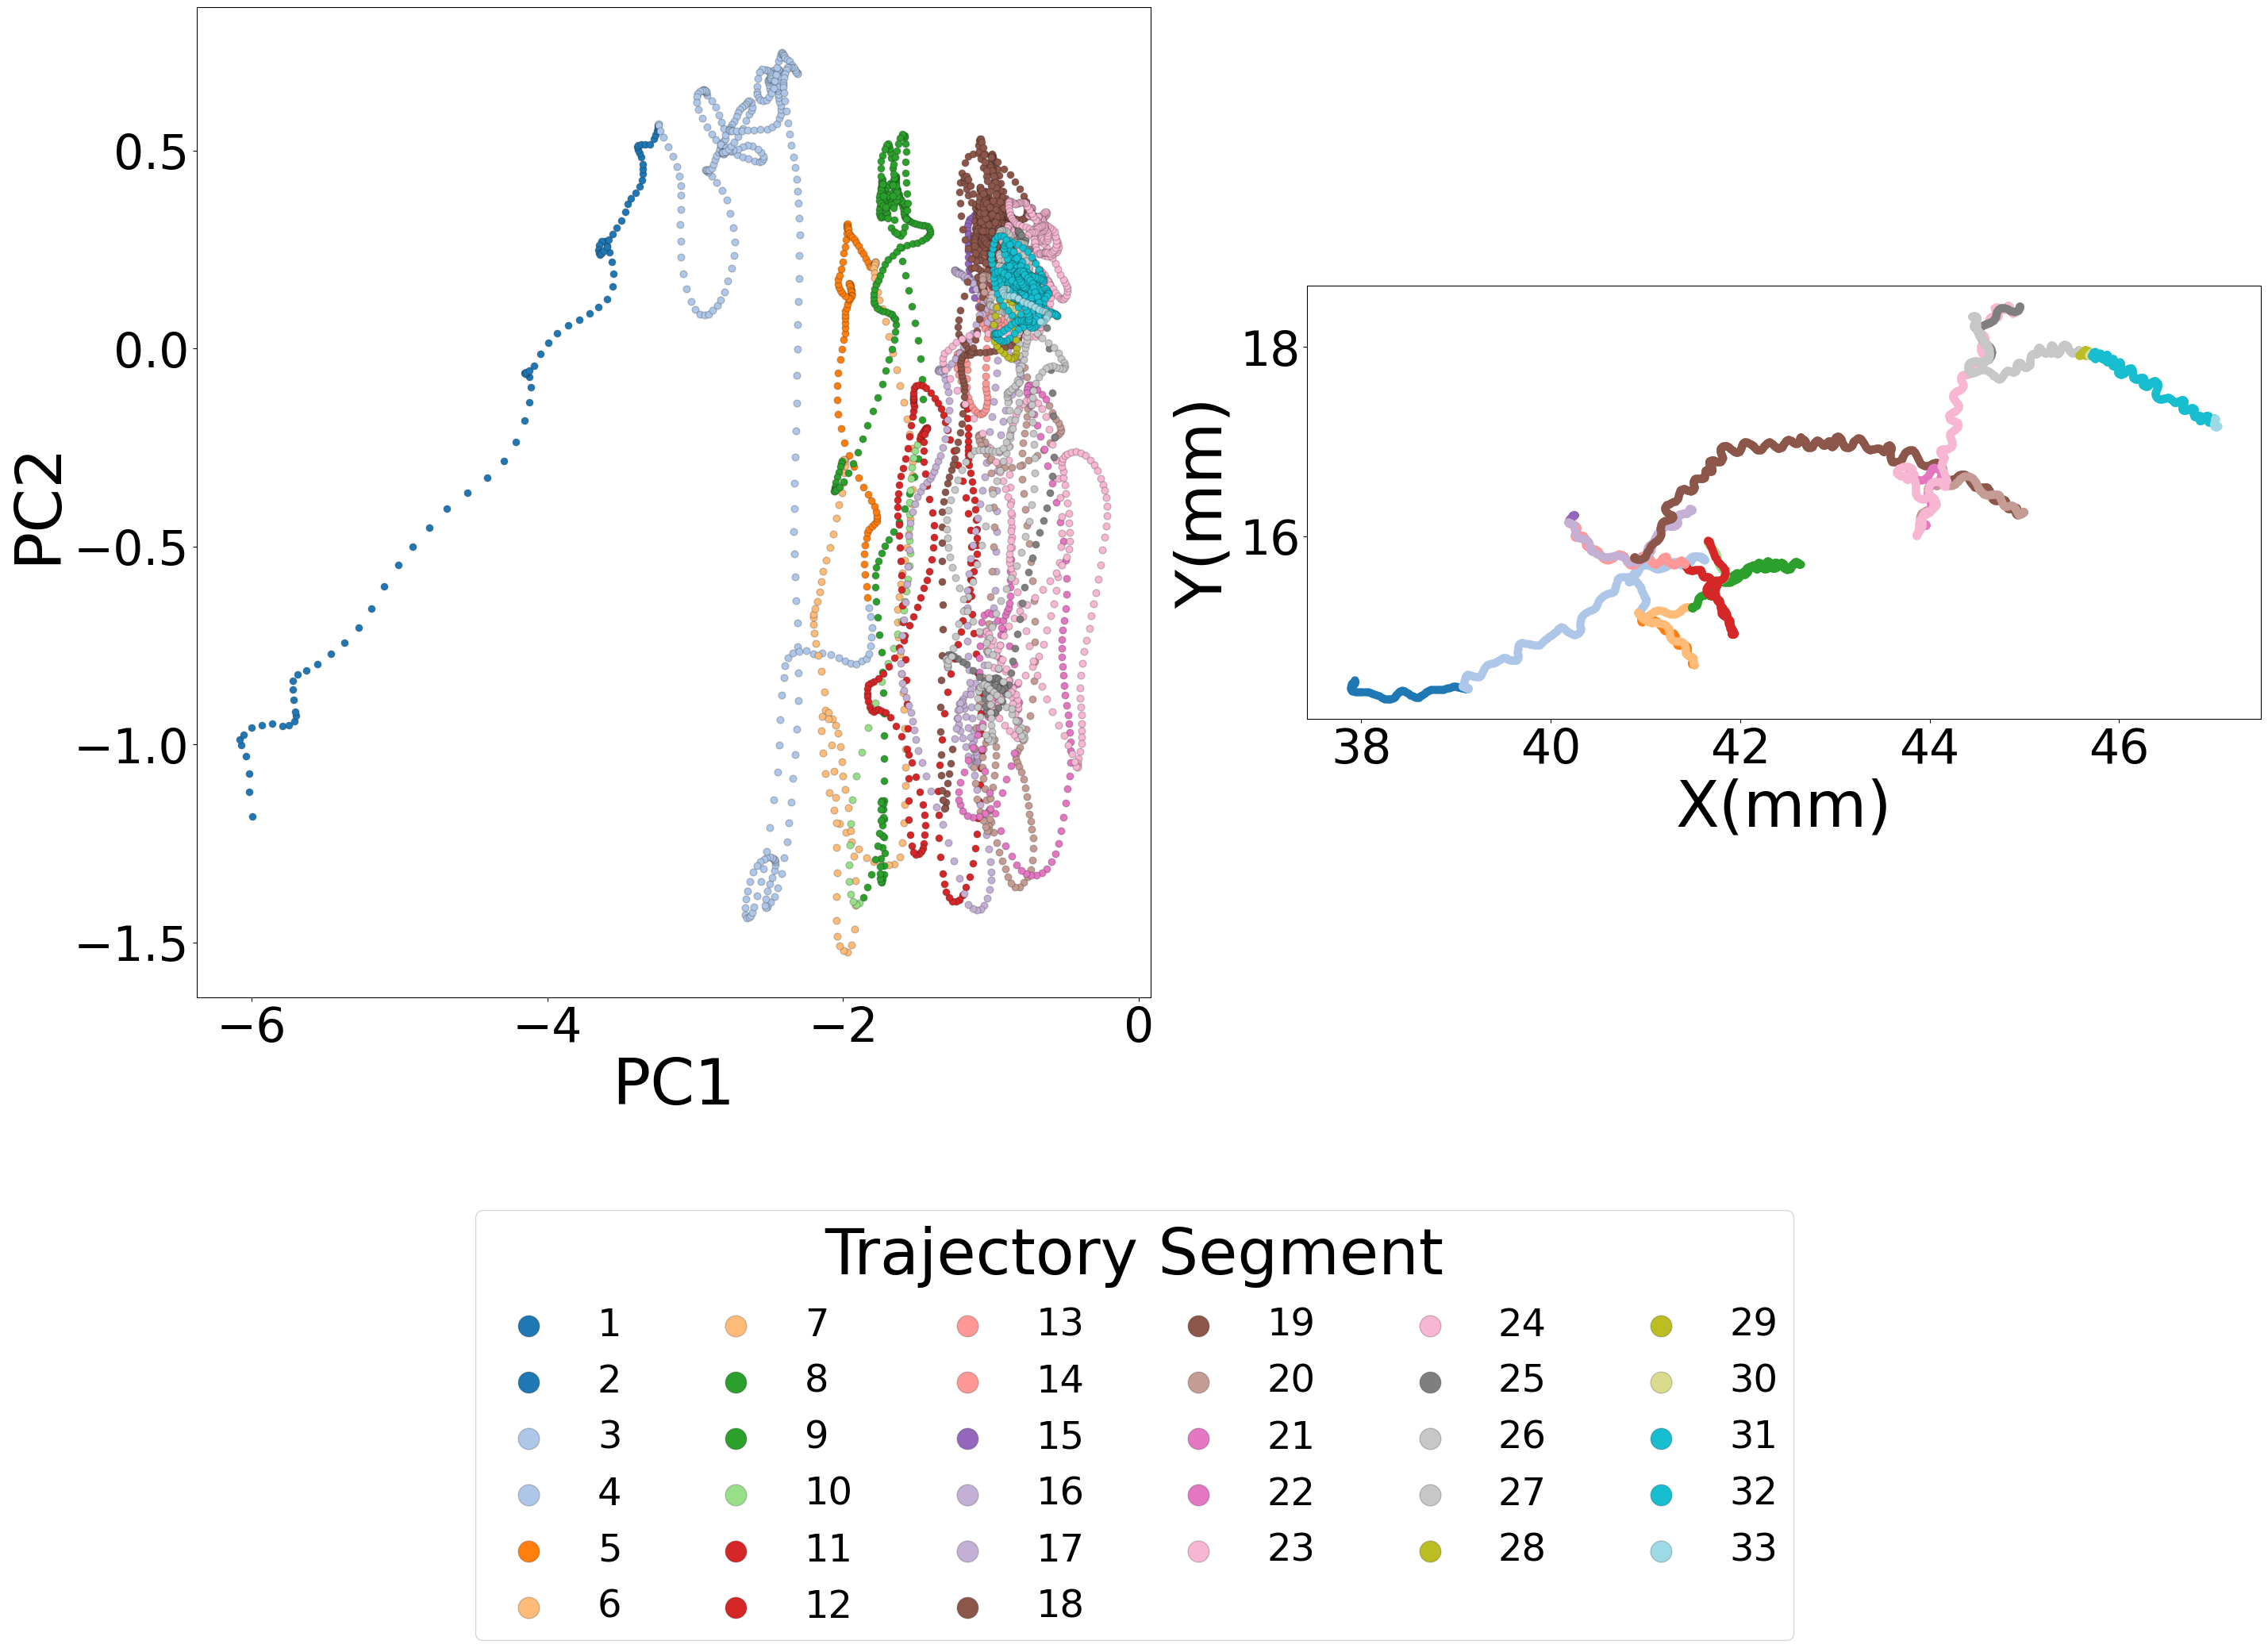

In [16]:
# 绘图主函数
if __name__ == "__main__":
    
    
    # 定义图片保存文件夹路径
    folder_path = os.path.join(p_f, 'Figs')
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)  # 创建文件夹
        print(f"文件夹 '{folder_path}' 已创建！")
    else:
        print(f"文件夹 '{folder_path}' 已存在！")
    
    # 定义全局变量
    global signal_save_path, idx, bound
    signal_save_path = folder_path

    choose_index = 0
    thresh = 5
    links=['ward','average','average','complete']
    affs=['euclidean','cosine','cityblock','cosine']
    vmin=-0.5
    vmax=1

    print('calcium_intensity.shape',calcium_intensity.shape)
    
    # 使用 np.corrcoef(calcium_intensity) 计算神经元钙信号的相关性矩阵
    # 聚类：使用 am.cluster 和指定的链接方式 (link=links[choose_index]) 
    # 和距离度量 (aff=affs[choose_index]) 对相关性矩阵进行聚类。
    idx=am.cluster(np.corrcoef(calcium_intensity),link=links[choose_index],aff=affs[choose_index])
    # idx为聚类之后的索引
    bound=np.cumsum(am.GetBound(np.corrcoef(calcium_intensity),link=links[choose_index],aff=affs[choose_index],
                                threshold=thresh).astype(int))
    # 调用 am.GetBound 计算矩阵分区的边界（bound），通过 np.cumsum 累积求和获取完整的边界数组
#     fig = PlotPmdCluster(np.corrcoef(calcium_intensity), idx, idx, bound, bound,
#                                    links[choose_index], affs[choose_index], vmin, vmax,
#                                    thresh,  'Neuron Index', 'jet', 35)
#     plt.savefig(f'{signal_save_path}/cluster_of_corrcoef_of_neurons.png')
    print('边界', bound)
#     bound = np.cumsum(bound)
#     print('边界数组:', bound)
    calcium_intensity = calcium_intensity[idx]

    fig_h = int(10*round(calcium_intensity.shape[0]/10))
    fig_w = int(0.7*round(calcium_intensity.shape[1]/100))
#     draw_calcium_curve(calcium_intensity,smooth_kernel=None,fig_size=(fig_w,fig_h),scale=1.5)

    font_size = 100
    start_indices_sel = np.array([0]+list(start_indices)+[calcium_intensity.shape[1]-1])
    neuron_ids = np.arange(calcium_intensity.shape[0])
    col_draw = ['smoothed_speed', 'smoothed_agl_speed', 'smoothed_CTX', 'smoothed_PC1', 'smoothed_PC2', 'Reorientation']
    
    calcium_heatmap(calcium_intensity,df_PCA_motion, col_draw,  neuron_ids, show_id_stride=10,
                    show_vol_stride=500, heatmap_range=(0,0.6),wspace=0.06, hspace=0.2,bound_cluster=bound,
                    unit_w=0.03, unit_h = 0.8, cal_height_ratio=30,start_indices=start_indices_sel, 
                    font_size=font_size, font_color='black',smooth_kernel=10, idx = idx, link = links[choose_index], 
                   aff = affs[choose_index],vmin = vmin, vmax = vmax, threshold=thresh, xlabel='Neuron Index',level=35)

In [17]:
# 画所有PC和行为组合的相关性

fs = 20
folder = r'Z:\data space+\C. elegans chemotaxis\20241223_WBI\121906fig'
pc_cols = ['PC1', 'PC2', 'PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10']
x_cols = ['X','Vol_time', 'speed', 'agl_speed','CTX_left','Reorientation']
for i,pc in enumerate(pc_cols):
    for j, x_col in enumerate(x_cols):
        plt.figure(figsize = (20,5))
        plt.scatter(df_nt_mx[x_col], df_nt_mx[pc])
        plt.xlabel(x_col, fontsize = fs)
        plt.ylabel(pc, fontsize = fs)
        filename = pc+'-'+x_col
        plt.savefig(os.path.join(folder,filename))

NameError: name 'df_nt_mx' is not defined

<Figure size 1920x480 with 0 Axes>

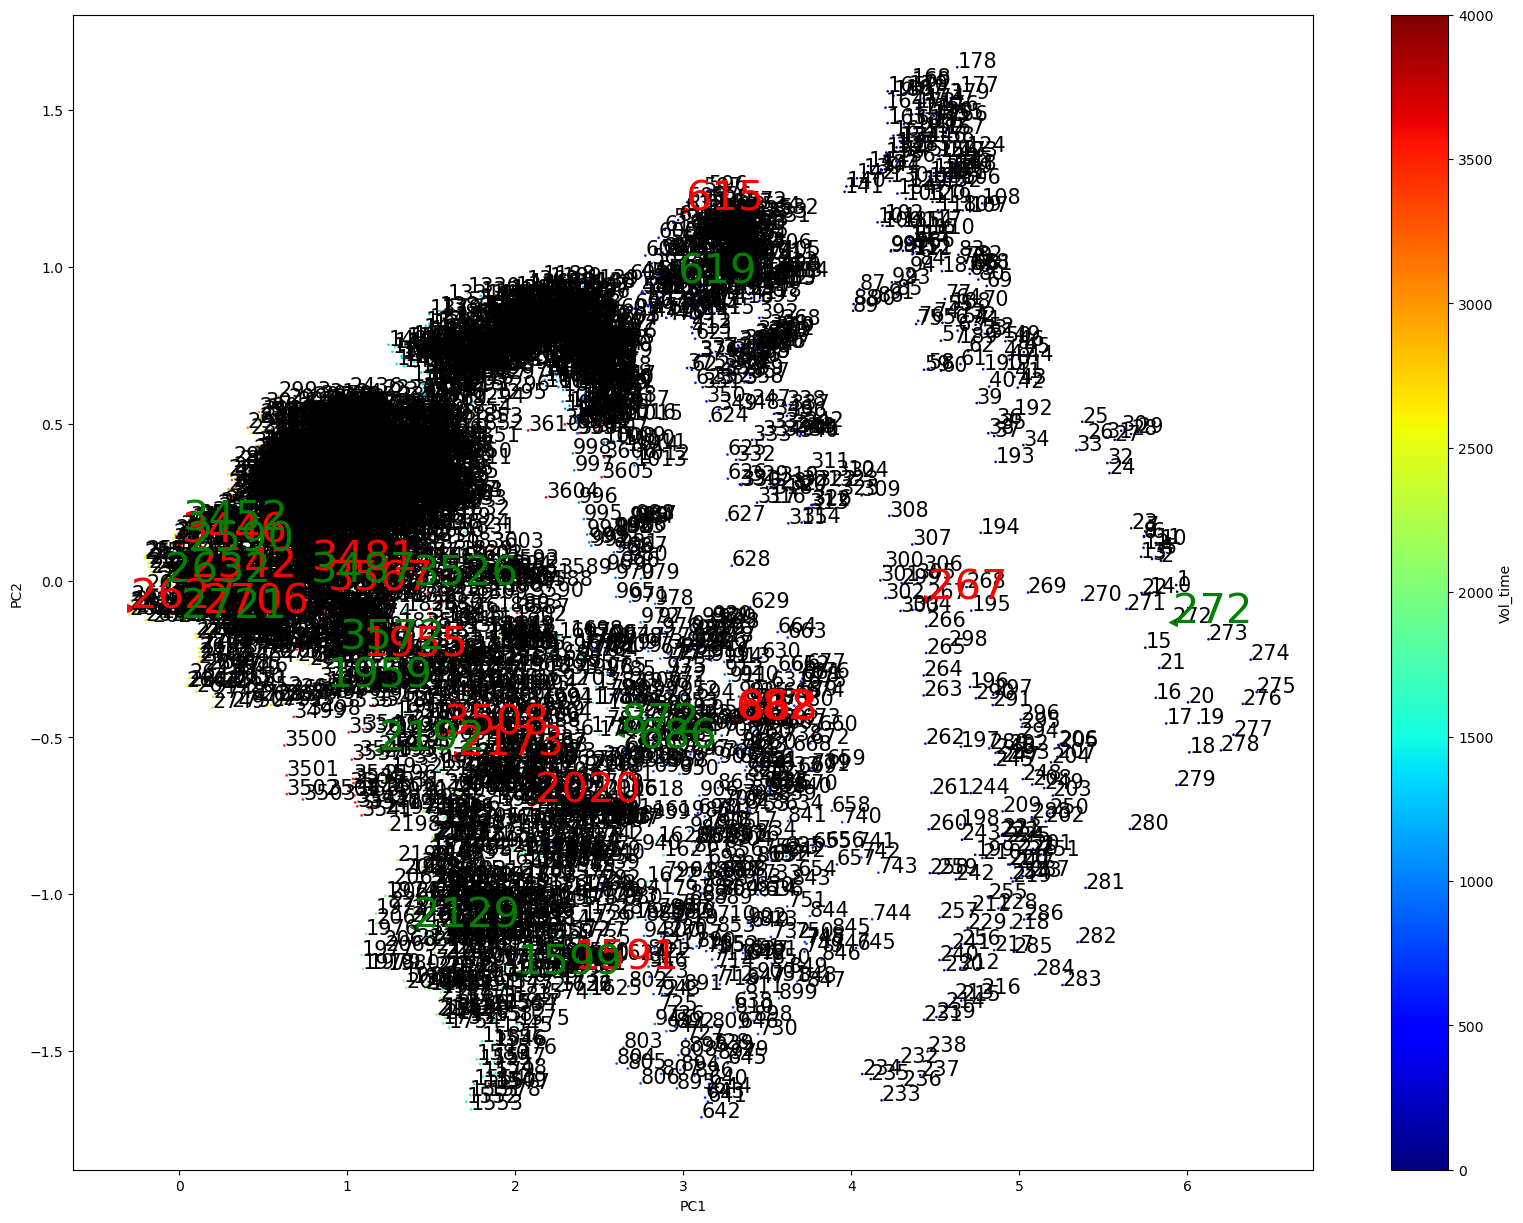

In [317]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

fig, ax = plt.subplots(figsize = (20,15))
fs = 30
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx.index,cmap='jet', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]

ls_all_idx = list(df_nt_mx.index)
str_all_ls_idx = list(map(str,ls_all_idx))

for x, y, text in zip(df_nt_mx['PC1'], df_nt_mx['PC2'], str_all_ls_idx):
    plt.text(x, y, text, color='k', fontsize=fs*0.5)

df_nt_end = df_nt_mx.loc[end_indices]
ls_s_idx = list(df_nt_start.index)
str_s_ls_idx = list(map(str,ls_s_idx))
for x, y, text in zip(df_nt_start['PC1'], df_nt_start['PC2'], str_s_ls_idx):
    plt.text(x, y, text, color='r', fontsize=fs)

ls_e_idx = list(df_nt_end.index)
str_e_ls_idx = list(map(str,ls_e_idx))
for x, y, text in zip(df_nt_end['PC1'], df_nt_end['PC2'], str_e_ls_idx):
    plt.text(x, y, text, color='g', fontsize=fs)    

start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=fs, marker='>', c = 'r')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=fs, marker='<', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


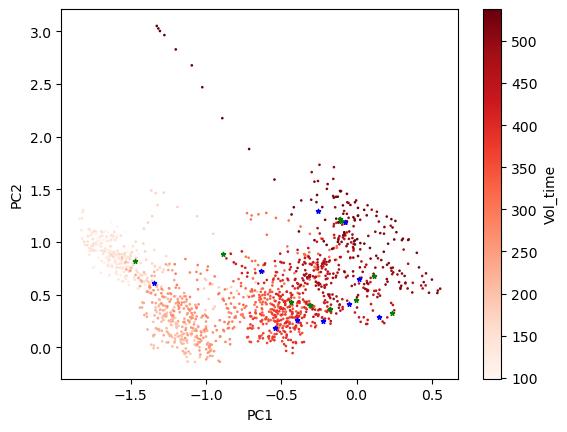

In [80]:

fig, ax = plt.subplots()
label = 'Vol_time'
# 绘制散点图，并返回散点图对象
sc = ax.scatter(df_nt_mx['PC1'], df_nt_mx['PC2'], c=df_nt_mx[label],cmap='Reds', s=0.8)
df_nt_start = df_nt_mx.loc[start_indices]
df_nt_end = df_nt_mx.loc[end_indices]
start = ax.scatter(df_nt_start['PC1'], df_nt_start['PC2'], s=10, marker='*', c = 'b')
end = ax.scatter(df_nt_end['PC1'], df_nt_end['PC2'], s=10, marker='*', c = 'g')
# sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=df_nt.X.max(), vmax=df_nt.X.min()))
# sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
plt.colorbar(sc, label=label)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [181]:
import matplotlib.colors as mcolors
# PC可视化
# pos_col = 'CTX_left'
nt_col = 'CTX_left'
x_label = pos_col
fs = 25
start = 3000
end=4000
df_nt_t = df_nt.loc[start:end,:]
# 可视化 PC1，颜色根据归一化 'X' 值设置
plt.figure(figsize=(15, 10), dpi=1000)
scatter = plt.scatter(df_nt_t.X, df_nt_t.Y,c = df_nt_t[nt_col], cmap='jet', s=2)
bar = plt.colorbar(scatter)  # 添加 colorbar 和标签
bar.ax.tick_params(labelsize=fs*0.5)
bar.set_label(label=nt_col, fontsize=fs*0.75)
plt.title(f'Trajectory label with{nt_col}from{start}to{end} ', fontsize=fs, pad = 20)
plt.xticks(fontsize=fs*0.5)
plt.yticks(fontsize=fs*0.5)
plt.xlabel('X(mm)', fontsize=fs*0.85)
ax = plt.gca()
ax.set_aspect(1)
plt.ylabel('Y(mm)', fontsize=fs*0.85)
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.show()

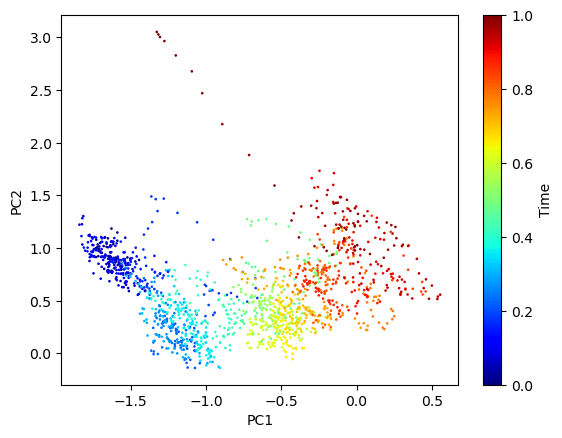

In [200]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
# colors = np.linspace(0, 1, 4001)
# cmap = ListedColormap(['red', 'blue'])
cmp=plt.get_cmap('jet') 
lin=np.linspace(0, 1, calcium_intensity.shape[1])
colors=cmp(lin)
t=calcium_intensity.shape[1]

fig, ax = plt.subplots()

# 绘制散点图，并返回散点图对象
sc = ax.scatter(xn[:t, 0], xn[:t, 1], c=colors[:t], s=0.8)
sm = ScalarMappable(cmap=cmp, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])  # 需要设置数组，即使它是空的

# 添加颜色条，并设置标签
cbar = fig.colorbar(sm, ax=ax, label='Time')
plt.xlabel('PC1')
plt.ylabel('PC2')
# cbar.set_ticks(np.linspace(0, 1, 20))  # 设置颜色条的刻度
# cbar.set_ticklabels(np.linspace(0, 1, 20)) 
# plt.colorbar(ax.collections[0],label='Time')
# plt.savefig(f'{save_p}/2d_pca.png')
plt.show()


Text(0, 0.5, 'PC1')

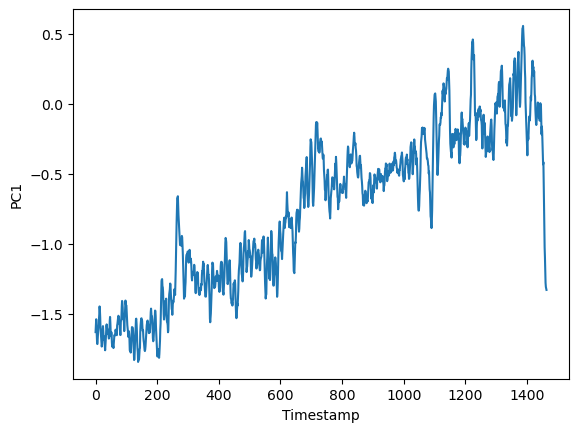

In [205]:
plt.plot(xn[:t,0])
plt.xlabel('Timestamp')
plt.ylabel('PC1')

Text(0.5, 0, 'PC3')

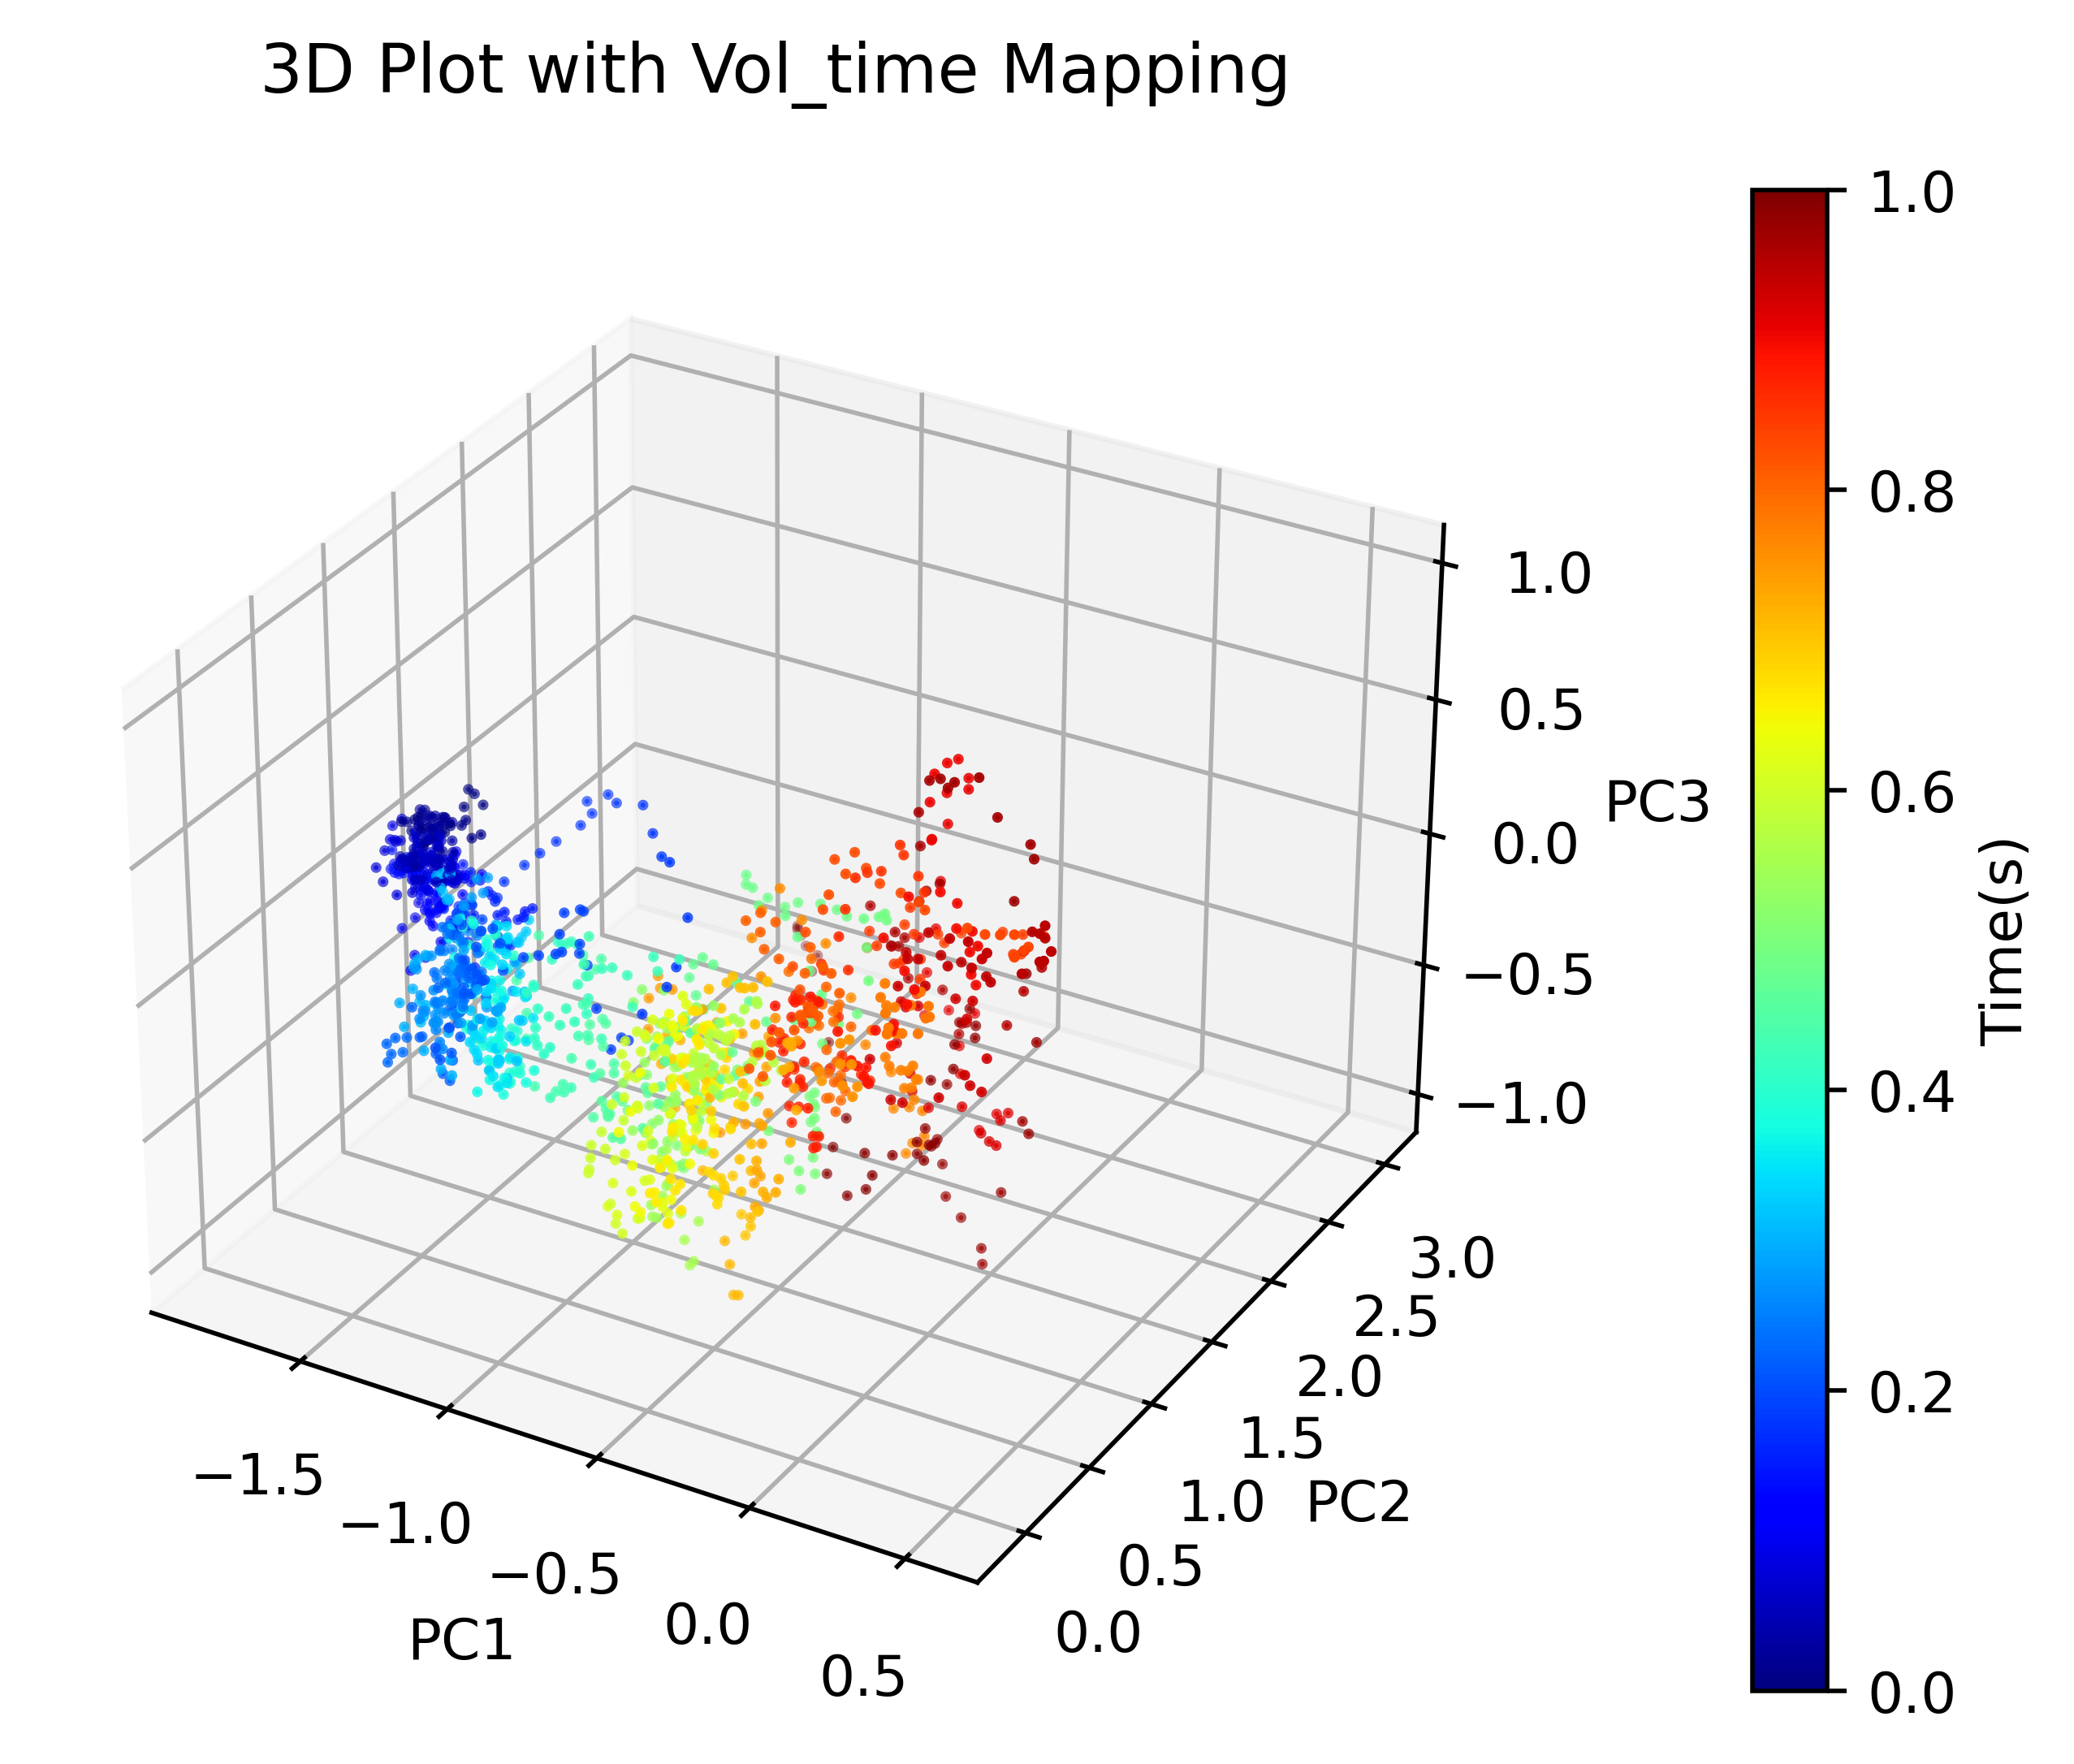

In [208]:
from mpl_toolkits.mplot3d import Axes3D

col = 'Vol_time'
x = xn[:t, 0]
y = xn[:t, 1]
z = xn[:t, 2]
color_values = lin[:t]  # 获取对应的颜色值

# 绘图
fig = plt.figure(dpi=500)
ax = fig.add_subplot(projection='3d')

# 使用 scatter 绘制带颜色的 3D 点
scatter = ax.scatter(x, y, z, c=color_values, cmap='jet', marker='o', s=0.8)

# 添加 colorbar
cbar = plt.colorbar(scatter, ax=ax, pad = 0.12)
cbar.set_label('Time(s)')

# 设置标题和标签
ax.set_title(f'3D Plot with {col} Mapping', pad=20)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')